<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab8.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# GANs

### Description
We build a GAN.

* GANs are generative models that learn to generate data, based on a min-max/adversarial game between a Generator (G) and Discriminator (D).
* The parameters of both Generator and Discriminator are optimized with Stochastic Gradient Descent (SGD) or RMSprop or Adam

This lab is modified from https://github.com/tomsercu/gan-tutorial-pytorch

### Deliverable
With the GAN architecture we:
1. Create a DataLoader for the CelebA dataset.
2. Create a Dataset and a DataLoader for an additional CIFAR dataset.
3. Implement the original GAN loss
4. Implement the training loop and train GAN model.


# Some cool demos:
* Progress over the last 5 years, from [Ian Goodfellow tweet](https://twitter.com/goodfellow_ian/status/1084973596236144640)

![tweet image](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/goodfellow_tweet.jpg?raw=1)

* CycleGAN translating horses into zebras: https://www.youtube.com/watch?v=9reHvktowLY
* CycleGAN teaser: ![cyclegan teaser image](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/cyclegan_teaser_high_res.jpg?raw=1)
* High resolution faces with StyleGAN https://www.youtube.com/watch?v=kSLJriaOumA
* https://ganbreeder.app web-interface to create images based on [BigGan](https://arxiv.org/abs/1809.11096)


# 1. GAN first introduction
[GAN picture](figs/gan_xavigiro.png)

<img src="https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/figs/gan_xavigiro.png?raw=1" alt="GAN picture" style="width: 700px;"/>

GANs are a class of unsupervised generative models which implicitly model the data density.

The basic setup is pictured above. There are two "competing" neural networks:
* The Generator wants to learn to generate realistic images that are indistinguishable from the real data. 
    - *input*: Gaussian noise random sample. *output*: a (higher dimensional) datapoint
* The Discriminator wants to tell the real & fake images apart.
    - *input*: datapoint/image, *output*: probability assigned to datapoint being real. Think binary classifier.
* The typical analogy: the generator is like a counterfeiter trying to look like real, the discriminator is the police trying to tell counterfeits from the real work.
* The key novelty of GANs is to pass the error signal (gradients) from the discriminator to the generator: the generator neural network uses the information from the competing discriminator neural network to know how to produce more realistic output.

Let's start with defining the generator G and discriminator D in pytorch.

# 2. Define the Generator and Discriminator

In [ ]:
!pip install torch==1.1.0
# !pip install torchvision==0.3.0
!pip install torchvision==0.2.1
# !wget 
# !mkdir test

import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
print(torch.__version__) 

%matplotlib inline
import matplotlib.pyplot as plt
import os, time

import itertools
import pickle
import imageio
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm

# You can use whatever display function you want. This is a really simple one that makes decent visualizations
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

     |████████████████████████████████| 676.9MB 18kB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.1.0 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 61kB 5.0MB/s 
  Found existing installation: torchvision 0.5.0
    Uninstalling torchvision-0.5.0:
      Successfully uninstalled torchvision-0.5.0
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


ImportError: ignored

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2020-03-27 03:03:05--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.176
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  20.9MB/s    in 67s     

2020-03-27 03:04:13 (20.4 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [ ]:
from torch.nn import functional as F

In [ ]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

## Defining the neural networks

In [ ]:
# helper function to initialize the weights using a normal distribution. 
# this was done in the original work (instead of xavier) and has been shown
# to help GAN performance
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [ ]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

In [ ]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

In [ ]:
#####
# instantiate a Generator and Discriminator according to their class definition.
#####

G = Generator()
D = Discriminator()
print(D)
print(G)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)
Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, m

## Testing the neural networks (forward pass)

In [ ]:
samples = torch.randn(5, 3, 64,64) # batch size x channels x width x height
D(samples)

tensor([[[[0.5683]]],


        [[[0.5879]]],


        [[[0.6093]]],


        [[[0.5304]]],


        [[[0.4817]]]], grad_fn=<SigmoidBackward>)

In [ ]:
class ConvClassifier(nn.Module):
    # initializers
    def __init__(self, d=8):
        super().__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 2)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 2)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 2)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, d*16, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(d*16)
        self.conv6 = nn.Conv2d(d*16, d*32, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(d*32)
        self.conv7 = nn.Conv2d(d*32, d*64, 4, 2, 2)
        self.conv7_bn = nn.BatchNorm2d(d*64)
        self.conv8 = nn.Conv2d(d*64, d*128, 4, 2, 1)
        self.conv8_bn = nn.BatchNorm2d(d*128)
        self.conv9 = nn.Conv2d(d*128, 1, 2, 1, 0)
        self.conv10 = nn.Linear(3,1)

    # # weight_init
    # def weight_init(self, mean, std):
    #     for m in self._modules:
    #         normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.conv5_bn(self.conv5(x)), 0.2)
        x = F.leaky_relu(self.conv6_bn(self.conv6(x)), 0.2)
        x = F.leaky_relu(self.conv7_bn(self.conv7(x)), 0.2)
        x = F.leaky_relu(self.conv8_bn(self.conv8(x)), 0.2)
        x = F.leaky_relu(self.conv9(x), 0.2)
        x = torch.sigmoid(self.conv10(x))

        return x

Things to try:
* What happens if you change the number of samples in a batch?
* What happens if you change the width/height of the input?
* What are the weights of the discriminator? You can get an iterator over them with `.parameters()` and `.named_parameters()`

In [ ]:
for name, p in D.named_parameters():
    print(name, p.shape)

conv1.weight torch.Size([128, 3, 4, 4])
conv1.bias torch.Size([128])
conv2.weight torch.Size([256, 128, 4, 4])
conv2.bias torch.Size([256])
conv2_bn.weight torch.Size([256])
conv2_bn.bias torch.Size([256])
conv3.weight torch.Size([512, 256, 4, 4])
conv3.bias torch.Size([512])
conv3_bn.weight torch.Size([512])
conv3_bn.bias torch.Size([512])
conv4.weight torch.Size([1024, 512, 4, 4])
conv4.bias torch.Size([1024])
conv4_bn.weight torch.Size([1024])
conv4_bn.bias torch.Size([1024])
conv5.weight torch.Size([1, 1024, 4, 4])
conv5.bias torch.Size([1])


We will think of the concatentation of all these discriminator weights in one big vector as $\theta_D$.

Similarly we name the concatentation of all the generator weights in one big vector $\theta_G$.

In [ ]:
for name, p in G.named_parameters():
    print(name, p.shape)

deconv1.weight torch.Size([100, 1024, 4, 4])
deconv1.bias torch.Size([1024])
deconv1_bn.weight torch.Size([1024])
deconv1_bn.bias torch.Size([1024])
deconv2.weight torch.Size([1024, 512, 4, 4])
deconv2.bias torch.Size([512])
deconv2_bn.weight torch.Size([512])
deconv2_bn.bias torch.Size([512])
deconv3.weight torch.Size([512, 256, 4, 4])
deconv3.bias torch.Size([256])
deconv3_bn.weight torch.Size([256])
deconv3_bn.bias torch.Size([256])
deconv4.weight torch.Size([256, 128, 4, 4])
deconv4.bias torch.Size([128])
deconv4_bn.weight torch.Size([128])
deconv4_bn.bias torch.Size([128])
deconv5.weight torch.Size([128, 3, 4, 4])
deconv5.bias torch.Size([3])


In [ ]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 100).view(-1,100,1,1)
x_gen = G(z)
#notice that the generated value is a batch of 2 images
x_gen.shape

torch.Size([2, 3, 64, 64])

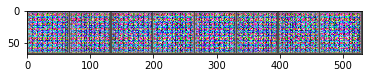

In [ ]:
z = torch.randn(8, 100).view(-1,100,1,1).cuda()
G = G.cuda()
show_imgs(G(z))

In traditional deep learning, you measure performance by looking at the loss value. In GANs, this does not work well because we are performing a Min-Max and the loss values may not be intuitively lower when the network is doing well. 

So, performance must be measured qualitatively, by looking at images. Therefore, you can sample random $z$ vectors every pass through the network to see how "novel" the generation is becoming. And you can also sample a single $z$ vector that is passed through the network every time to see how a single example progresses during training. 

In [ ]:
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), requires_grad=False)

## Loading the data and computing forward pass

In [ ]:
import requests

batch_size = 128
lr = 0.0002
train_epoch = 3

img_size = 64

#download the data, and change the filepath
class CelebADataset(Dataset):
  def __init__(self, dataset, root="data_faces/", train=True):
    
    self.image_folder = dataset
    
  def __getitem__(self,index):
    img = self.image_folder[index]
    return img
  
  def __len__(self):
    return len(self.image_folder)

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)

# download_file_from_google_drive(id="CelebA", destination='/content/gdrive/\"My Drive\"/test')
  
print(torch.cuda.memory_allocated(0) / 1e9)

# possible sources for celeba: torchvision datasets, or this google drive link: https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
dataset = datasets.ImageFolder('./data_faces',
                           transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])) # THIS IS WHAT WE'LL PASS INTO THE DATASET CLASS
##### Create the dataloader #####
celeb_dataset = CelebADataset(dataset)

0.050673152


In [ ]:
!pip install Pillow==4.3.0
!pip install PIL
!pip install image
import PIL.Image as Image
""" data """
crop_size = 108
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

data_loader = DataLoader(celeb_dataset,batch_size=64)

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


Dataset and DataLoader are abstractions to help us iterate over the data in random order.

Let's look at a sample:

## Examples of images from the dataset 

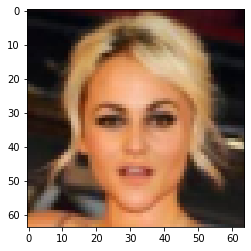

In [ ]:
ix=140
x, _ = dataset[ix]
show_imgs(x)

Feed the image into the discriminator; the output will be the probability the (untrained) discriminator assigns to this sample being real.

In [ ]:
# for one image:
Dscore = D(x.unsqueeze(0))
Dscore

tensor([[[[0.5267]]]], grad_fn=<SigmoidBackward>)

In [ ]:
# How you can get a batch of images from the dataloader:
train_loader = data_loader
xbatch, _ = iter(train_loader).next()
xbatch.shape
D(xbatch)
D(xbatch).shape

torch.Size([64, 1, 1, 1])

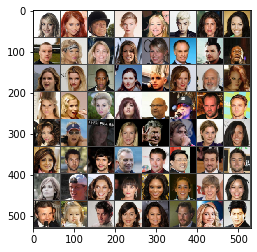

In [ ]:
show_imgs(xbatch)

# GAN Training

We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. 

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.

BCE takes care of the log, you won't manually compute any Log values


In [ ]:
G = Generator(128)
D = Discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G = G.cuda()
D = D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
num_iter = 0
collect_x_gen = []
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in tqdm(train_loader):
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        #####
        # create y_real_ and y_fake_ tensors we will use in your BCE loss to push probabilities 
        # in the proper direction
        # y_real_ will be a tensor of all ones, because we want whatever is output by the generator
        # to be more likely to be real and you want the discriminator to recognize real images
        # y_fake_ then is a tensor of all zeros, because we want the discriminator to recognize fake images
        #####
        
        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        x_, y_real, y_fake = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        
        #####
        # pass x_ through the decoder to get D_result
        # you will need to squeeze() the output before passing it to BCE_loss
        # compute D_real_loss using BCE_loss and the proper y tensor from above
        # we are trying to make the discriminator recognize the real image properly
        #####

        bce_loss = nn.BCELoss()
        dx = D(x_)
        loss_real = bce_loss(dx.squeeze(), y_real)

        #####
        # sample a z vector (remember to view(-1,100,1,1))
        # pass the z vector to the GPU and through your generator
        # this will create G_result
        #####

        zs = torch.randn(mini_batch * 100).view(-1,100,1,1).cuda()
        
        #####
        # pass G_result through the discriminator and get D_result
        # we will need to squeeze() the output of the discriminator
        # compute D_fake_loss for the generated images by using BCE_loss and the proper y_tensor
        # we are trying to make the discriminator recognize the fake image properly
        # reduce D_fake_loss to the mean value
        #####

        # gz = G(zs)
        dgz = D(G(zs))
        loss_fake = bce_loss(dgz.squeeze(), y_fake)

        #####
        # sum D_real_loss and D_fake_loss to get D_train_loss
        # compute the gradients
        # step the optimizer
        #####

        D_train_loss = loss_real + loss_fake
        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        #####
        # sample a z vector (viewed properly) and pass it to the GPU and through the generator
        # compute the discriminated value of the generated image, properly squeezing the output
        # get G_train_loss by using BCE_loss and the proper y_tensor
        # we are trying to make the generator generate real images
        # compute the gradients
        # step the optimizer
        #####

        zs_g = torch.randn(mini_batch * 100).view(-1,100,1,1).cuda()
        gz_g = G(zs_g)
        dgz_g = D(gz_g)
        y_truth = torch.ones(mini_batch)
        y_truth = Variable(y_truth.cuda())
        loss = bce_loss(dgz_g.squeeze(), y_truth) 

        G_train_loss = loss
        loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

        num_iter += 1

    # generate a fixed_z_ image and save
    x_gen = G(fixed_z_)
    collect_x_gen.append(x_gen.detach().clone())
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    # print out statistics
    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
  

  0%|          | 0/3166 [00:00<?, ?it/s]

[1/3] - ptime: 3628.31, loss_d: 0.714, loss_g: 4.602


  0%|          | 0/3166 [00:00<?, ?it/s]

[2/3] - ptime: 3612.25, loss_d: 0.819, loss_g: 2.435


100%|██████████| 3166/3166 [59:49<00:00,  1.06s/it]

[3/3] - ptime: 3589.08, loss_d: 0.794, loss_g: 2.320


# Examples of faces generated from our GAN!

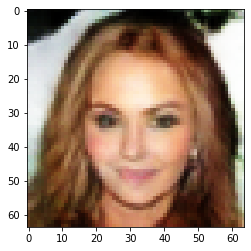

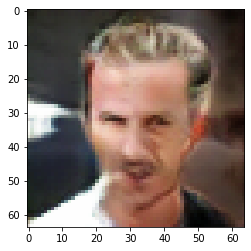

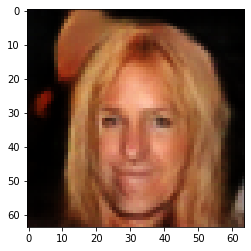

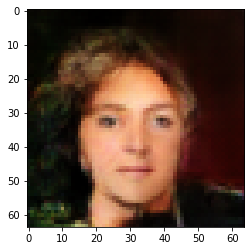

In [ ]:
G_result = G(zs)
for i in range(4):
  show_imgs(G_result[i])


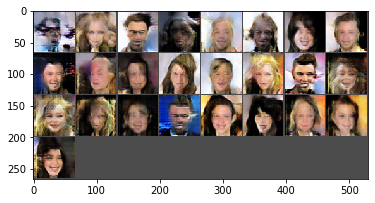

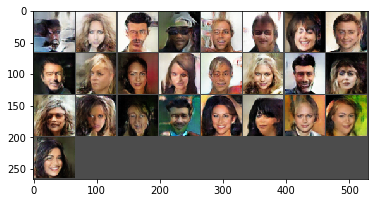

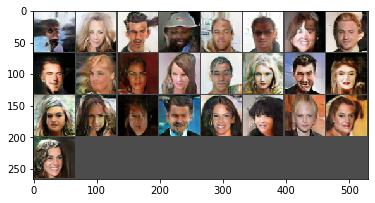

In [ ]:
for x_gen in collect_x_gen:
    show_imgs(x_gen)

Now generate something the CIFAR dataset

In [ ]:
!mkdir cifar

In [ ]:
G = Generator()
D = Discriminator()
print(D)
print(G)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)
Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, m

In [ ]:
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), requires_grad=False)

In [ ]:
import requests

batch_size = 128
lr = 0.0002
train_epoch = 3

img_size = 64

dataset = torchvision.datasets.CIFAR10(root="./cifar", transform=transforms.Compose([
                               transforms.Resize(img_size),
                               transforms.CenterCrop(img_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]), download=True, train=True)

Files already downloaded and verified


In [ ]:
class CifarDataset(Dataset):
  def __init__(self, dataset, root="cifar/", train=True):
    # if download and not os.path.exists(os.path.join(root, 'celeb_data')):
    #   datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
    #   self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
    #   self.extract_tar(os.path.join(root, 'cancer_data.tar'))

    # postfix = 'train' if train else 'test'
    # root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.image_folder = dataset
    
  def __getitem__(self,index):
    img = self.image_folder[index]
    return img
  
  def __len__(self):
    return len(self.image_folder)

In [ ]:
cifar_dataset = CifarDataset(dataset)

!pip install Pillow==4.3.0
!pip install PIL
!pip install image
import PIL.Image as Image
""" data """
crop_size = 108
re_size = 64
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

data_loader = DataLoader(cifar_dataset,batch_size=64,shuffle=True)

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [ ]:
# How you can get a batch of images from the dataloader:
train_loader = data_loader
xbatch, _ = iter(train_loader).next()
xbatch.shape
D(xbatch)
D(xbatch).shape

torch.Size([64, 1, 1, 1])

## Example of image from dataset (CIFAR images very varied)

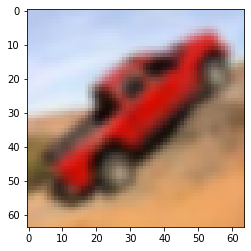

In [ ]:
ix=140
x, _ = dataset[ix]
show_imgs(x)

In [ ]:
G = Generator(128)
D = Discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G = G.cuda()
D = D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
# train_epoch = 3
num_iter = 0
collect_x_gen = []
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in tqdm(train_loader):
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        #####
        # create y_real_ and y_fake_ tensors you will use in your BCE loss to push probabilities 
        # in the proper direction
        # y_real_ will be a tensor of all ones, because you want whatever is output by the generator
        # to be more likely to be real and you want the discriminator to recognize real images
        # y_fake_ then is a tensor of all zeros, because you want the discriminator to recognize fake images
        #####
        
        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        x_, y_real, y_fake = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        
        #####
        # pass x_ through the decoder to get D_result
        # you will need to squeeze() the output before passing it to BCE_loss
        # compute D_real_loss using BCE_loss and the proper y tensor from above
        # you are trying to make the discriminator recognize the real image properly
        #####
        bce_loss = nn.BCELoss()
        dx = D(x_)
        loss_real = bce_loss(dx.squeeze(), y_real)

        #####
        # sample a z vector (remember to view(-1,100,1,1))
        # pass the z vector to the GPU and through your generator
        # this will create G_result
        #####

        zs = torch.randn(mini_batch * 100).view(-1,100,1,1).cuda()
        
        #####
        # pass G_result through the discriminator and get D_result
        # you will need to squeeze() the output of the discriminator
        # compute D_fake_loss for the generated images by using BCE_loss and the proper y_tensor
        # you are trying to make the discriminator recognize the fake image properly
        # reduce D_fake_loss to the mean value
        #####

        # gz = G(zs)
        dgz = D(G(zs))
        loss_fake = bce_loss(dgz.squeeze(), y_fake)

        #####
        # sum D_real_loss and D_fake_loss to get D_train_loss
        # compute the gradients
        # step the optimizer
        #####

        D_train_loss = loss_real + loss_fake
        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        #####
        # sample a z vector (viewed properly) and pass it to the GPU and through the generator
        # compute the discriminated value of the generated image, properly squeezing the output
        # get G_train_loss by using BCE_loss and the proper y_tensor
        # you are trying to make the generator generate real images
        # compute the gradients
        # step the optimizer
        #####

        zs_g = torch.randn(mini_batch * 100).view(-1,100,1,1).cuda()
        gz_g = G(zs_g)
        dgz_g = D(gz_g)
        y_truth = torch.ones(mini_batch)
        y_truth = Variable(y_truth.cuda())
        loss = bce_loss(dgz_g.squeeze(), y_truth) 

        G_train_loss = loss
        loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

        num_iter += 1

    # generate a fixed_z_ image and save
    x_gen = G(fixed_z_)
    collect_x_gen.append(x_gen.detach().clone())
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    # print out statistics
    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    
    # show_imgs(G_result[:4])



  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 1/782 [00:01<14:37,  1.12s/it]

  0%|          | 2/782 [00:02<14:26,  1.11s/it]

  0%|          | 3/782 [00:03<14:18,  1.10s/it]

  1%|          | 4/782 [00:04<14:12,  1.10s/it]

  1%|          | 5/782 [00:05<14:05,  1.09s/it]

  1%|          | 6/782 [00:06<13:58,  1.08s/it]

  1%|          | 7/782 [00:07<13:58,  1.08s/it]

  1%|          | 8/782 [00:08<13:57,  1.08s/it]

  1%|          | 9/782 [00:09<13:55,  1.08s/it]

  1%|▏         | 10/782 [00:10<13:54,  1.08s/it]

  1%|▏         | 11/782 [00:11<13:53,  1.08s/it]

  2%|▏         | 12/782 [00:12<13:51,  1.08s/it]

  2%|▏         | 13/782 [00:14<13:50,  1.08s/it]

  2%|▏         | 14/782 [00:15<13:51,  1.08s/it]

  2%|▏         | 15/782 [00:16<13:47,  1.08s/it]

  2%|▏         | 16/782 [00:17<13:43,  1.08s/it]

  2%|▏         | 17/782 [00:18<13:41,  1.07s/it]

  2%|▏         | 18/782 [00:19<13:41,  1.08s/it]

  2%|▏         | 19/782 [00:20<13:40,  1.08s/it]

  3%|▎         |

[1/3] - ptime: 835.21, loss_d: 0.559, loss_g: 8.825




  0%|          | 1/782 [00:01<14:33,  1.12s/it]

  0%|          | 2/782 [00:02<14:23,  1.11s/it]

  0%|          | 3/782 [00:03<14:09,  1.09s/it]

  1%|          | 4/782 [00:04<14:01,  1.08s/it]

  1%|          | 5/782 [00:05<13:59,  1.08s/it]

  1%|          | 6/782 [00:06<13:55,  1.08s/it]

  1%|          | 7/782 [00:07<13:53,  1.08s/it]

  1%|          | 8/782 [00:08<13:51,  1.07s/it]

  1%|          | 9/782 [00:09<13:48,  1.07s/it]

  1%|▏         | 10/782 [00:10<13:47,  1.07s/it]

  1%|▏         | 11/782 [00:11<13:45,  1.07s/it]

  2%|▏         | 12/782 [00:12<13:41,  1.07s/it]

  2%|▏         | 13/782 [00:13<13:41,  1.07s/it]

  2%|▏         | 14/782 [00:15<13:41,  1.07s/it]

  2%|▏         | 15/782 [00:16<13:40,  1.07s/it]

  2%|▏         | 16/782 [00:17<13:39,  1.07s/it]

  2%|▏         | 17/782 [00:18<13:39,  1.07s/it]

  2%|▏         | 18/782 [00:19<13:38,  1.07s/it]

  2%|▏         | 19/782 [00:20<13:35,  1.07s/it]

  3%|▎         | 20/782 [00:21<13:37,  1.07s/it]

  3%|▎ 

[2/3] - ptime: 835.25, loss_d: 0.707, loss_g: 3.661




  0%|          | 1/782 [00:01<14:43,  1.13s/it]

  0%|          | 2/782 [00:02<14:29,  1.11s/it]

  0%|          | 3/782 [00:03<14:15,  1.10s/it]

  1%|          | 4/782 [00:04<14:05,  1.09s/it]

  1%|          | 5/782 [00:05<13:59,  1.08s/it]

  1%|          | 6/782 [00:06<13:57,  1.08s/it]

  1%|          | 7/782 [00:07<13:56,  1.08s/it]

  1%|          | 8/782 [00:08<13:54,  1.08s/it]

  1%|          | 9/782 [00:09<13:50,  1.07s/it]

  1%|▏         | 10/782 [00:10<13:49,  1.07s/it]

  1%|▏         | 11/782 [00:11<13:45,  1.07s/it]

  2%|▏         | 12/782 [00:12<13:42,  1.07s/it]

  2%|▏         | 13/782 [00:13<13:41,  1.07s/it]

  2%|▏         | 14/782 [00:15<13:38,  1.07s/it]

  2%|▏         | 15/782 [00:16<13:33,  1.06s/it]

  2%|▏         | 16/782 [00:17<13:31,  1.06s/it]

  2%|▏         | 17/782 [00:18<13:33,  1.06s/it]

  2%|▏         | 18/782 [00:19<13:33,  1.06s/it]

  2%|▏         | 19/782 [00:20<13:33,  1.07s/it]

  3%|▎         | 20/782 [00:21<13:32,  1.07s/it]

  3%|▎ 

[3/3] - ptime: 834.59, loss_d: 0.708, loss_g: 3.266


# Examples of GAN-generated images

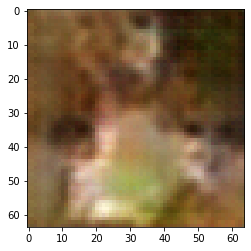

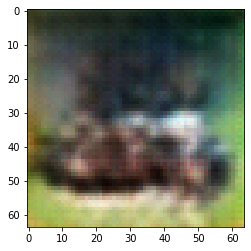

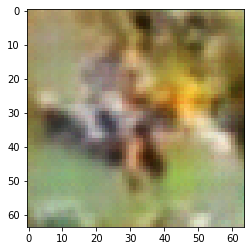

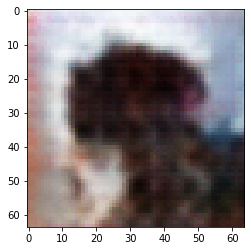

In [ ]:
G_result = G(zs)
for i in range(4):
  show_imgs(G_result[i])

In [ ]:
# Random stuff: ignore
import torch
import numpy as np
X = torch.randn(1,2,3,4,5,6)
dim_inds = list(np.arange(len(X.size())))
permuted_dims = [dim_inds[-1]] + dim_inds[:-1]
X = X.permute(tuple(permuted_dims))

# A demo of a state of the art GAN and "painting" with them in your browser:

https://gandissect.csail.mit.edu

By our colleagues at the MIT-IBM Watson AI Lab.


# Where to go from here
* Use a more exciting datasets - check out [the pytorch torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) to get started quickly.
* The [original GAN paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets)
* The [DCGAN paper](https://arxiv.org/abs/1511.06434) which made it all work much better for images. Start from: pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
* Newer generations of loss functions measure different distances between distributions $p_{data}$ and $p_G$. For example [WGAN](https://github.com/martinarjovsky/WassersteinGAN), [WGAN-GP](https://arxiv.org/abs/1704.00028), [Fisher GAN](https://arxiv.org/abs/1705.09675), [Sobolev GAN](https://arxiv.org/abs/1711.04894), many more. They often have better stability properties wrt the original GAN loss.

# References for this tutorial from Brigham Young University and the PCCL
* pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich
* [Medium blog post](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f) by Diego Gomez Mosquera
* [Material made for ITDS course at CUNY](https://github.com/grantmlong/itds2019/blob/master/lecture-6/DL_lab_solutions.ipynb) by Tom Sercu (that's me!)
* [Blog post](https://towardsdatascience.com/graduating-in-gans-going-from-understanding-generative-adversarial-networks-to-running-your-own-39804c283399) by Cecelia Shao
* [GAN overview image](https://www.slideshare.net/xavigiro/deep-learning-for-computer-vision-generative-models-and-adversarial-training-upc-2016) from Xavier Giro